### 【第三周作业】
+ 1. 使用pytorch搭建神经网络模型，实现对KMNIST数据集的训练。
https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST
+ 2. 尝试调整模型结构（变更神经元数量，增加隐藏层）来提升模型预测的准确率
+ 3. 调试超参数，观察学习率和批次大小对训练的影响。

### 结论
当学习率为 0.001 时，数据集比例越高，批次数越高，训练次数越多，准确率越高。

通过生成的线形图可以看出，当train_rate = 0.8, batch_size = 128, epochs = 20，learn_rate = 0.001 时，预测准确率最好。

通过调整隐藏层数量，发现隐藏层并不是越多越好，可以多次试验找到合适数值。本地测试时 ，层数为3层时已经是较好的结果。

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt

In [15]:
# 检查设备
device ="cuda" if torch.cuda.is_available() else "cpu" 
print(f"使用 {device} 设备")

使用 cpu 设备


In [26]:
# 定义神经网络模型
class NeuralNetwork(nn.Module):
    def __init__(self,linear_relu_stack):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = linear_relu_stack
       
    # 前向传播
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits  

In [27]:
def init_dataset():
    train_data = datasets.KMNIST(
        root="./dataset/data_train_KMNIST",
        train=True,
        download=True,
        transform=ToTensor()
    )
    test_data = datasets.KMNIST(
        root="./dataset/data_test_KMNIST",
        train=False,
        download=True ,
        transform=ToTensor()
    )
    return train_data,test_data

def init_model(lr,linear_relu_stack):
    # 使用模型
    model = NeuralNetwork(linear_relu_stack).to(device)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr)
    return model,criterion,optimizer



In [28]:
# 定义一个训练方法
def train_function(train_loader,eval_loader,epochs,lr,linear_relu_stack):# 模型、训练次数
    train_loss = [] # 记录差值
    train_accuary = []# 记录准确率
    eval_loss = [] # 记录差值
    eval_accuary = []# 记录准确率

    model,criterion,optimizer = init_model(lr,linear_relu_stack)

    print(f"Model Train is start !")
    for epoch in range(epochs):
        # 开始训练
        model.train()
        train_loss_data = 0.0
        train_num = 0
        train_num_right = 0

        for images,labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # 梯度值清零
            model_output = model(images)# 模型对输入数据的预测结果，输出张量。其实就是调用了前向传播，这个地方有封装
            loss = criterion(model_output,labels)# 将 model_output 与真实标签 labels 输入损失函数（如交叉熵损失）

            loss.backward() # 反向传播计算得到每个参数的梯度值w
            optimizer.step() # 根据梯度更新网络w参数

            train_loss_data += loss.item() # 统计损失值
            p, predicted = torch.max(model_output.data, 1)# 从模型输出的张量当中提取预测结果，p 是最大值，predict是预测类别索引
            train_num += labels.size(0)
            train_num_right += (predicted == labels).sum().item()
        
        # 计算训练集指标
        train_epoch_loss = train_loss_data / len(train_loader)# 平均损失值
        train_epoch_acc = train_num_right / train_num # 正确率
        train_loss.append(train_epoch_loss) # 记录此次训练的损失值
        train_accuary.append(train_epoch_acc) # 记录此次训练的正确概率

        # 开始验证
        model.eval()# 模型切换到评估模式
        eval_loss_data = 0.0
        eval_num = 0
        eval_num_right = 0
        with torch.no_grad():#禁用梯度计算
            for images, labels in eval_loader:
                images = images.to(device)
                labels = labels.to(device)
                model_output = model(images)# 模型对输入数据的预测结果，输出张量。其实就是调用了前向传播，这个地方有封装
                loss = criterion(model_output,labels)# 将 model_output 与真实标签 labels 输入损失函数（如交叉熵损失）
                eval_loss_data += loss.item() # 统计损失值
                p, predicted = torch.max(model_output.data, 1)# 从模型输出的张量当中提取预测结果，p 是最大值，predict是预测类别索引
                eval_num += labels.size(0)
                eval_num_right += (predicted == labels).sum().item()
        # 计算验证集指标
        eval_epoch_loss = eval_loss_data / len(eval_loader)# 平均损失值
        eval_epoch_acc = eval_num_right / eval_num # 正确率
        eval_loss.append(eval_epoch_loss) # 记录此次训练的损失值
        eval_accuary.append(eval_epoch_acc) # 记录此次训练的正确概率

        print(f"Epoch-{epoch+1}:  train loss = {train_epoch_loss:.4f}, train accuary = {train_epoch_acc:.4f} ; eval loss = {eval_epoch_loss:.4f}, eval accuary = {eval_epoch_acc:.4f}  ;")
    print(f"Model Train is end !")
    print(f"------------------------------------------------------------------------------------------------------")
    
    return train_loss, train_accuary, eval_loss, eval_accuary

In [29]:
def train_params_adjust(train_rate,batch_size,epochs,lr,linear_relu_stack):
    train_data,test_data = init_dataset()
    # 划分数据集和训练集
    train_size = int(train_rate * len(train_data))
    check_size = int(len(train_data)-train_size)
    # 例如：0.8  即是 随机划分为 80% 训练集 + 20% 验证集
    train_data,check_data = torch.utils.data.random_split(train_data,[train_size,check_size])

    # 创建数据加载器,将数据集划分为固定大小的 ‌mini-batch‌，便于模型批量处理数据，提升训练效率‌
    # 通过 shuffle=True 参数在每个 epoch 开始时 ‌随机重排数据顺序‌，防止模型因数据顺序产生过拟合‌,适用场景：训练阶段通常开启 shuffle，验证/测试阶段关闭‌
    # 训练数据加载
    train_loader = DataLoader(train_data , batch_size = batch_size , shuffle = True)
    # 验证数据加载
    eval_loader = DataLoader(check_data , batch_size = batch_size)
    # 测试数据加载
    test_loader = DataLoader(test_data , batch_size = batch_size)
    # 开始训练
    train_loss, train_accuary, eval_loss, eval_accuary = train_function(train_loader,eval_loader,epochs,lr,linear_relu_stack)
    return train_loss, train_accuary, eval_loss, eval_accuary   

def train_result_plt(train_loss, train_accuary, eval_loss, eval_accuary,text,rows,row):
    plt.subplot(rows, 2, (row * 2)-1)
    plt.plot(train_loss, label='Train_loss')
    plt.plot(eval_loss, label='Eval_loss')
    plt.title(text)
    plt.xlabel('epoch')
    plt.ylabel('loss_value')
    plt.legend()

    plt.subplot(rows, 2, row * 2)
    plt.plot(train_accuary, label='Train_accuracy')
    plt.plot(eval_accuary, label='Eval_accuracy')
    plt.title(text)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()


In [ ]:
rates = [0.8] # 划分数据集的比例
epochs = [10] # 训练次数
lrs = [0.001,0.01]
batches = [64,128] # 数据集划分为固定大小的 ‌mini-batch‌，便于模型批量处理数据，提升训练效率‌

def multi_train(linear_relu_stack,graphname):
    rows = len(batches) * len(epochs) * len(rates) * len(lrs)
    row = 0
    plt.figure(figsize=(12, 4* rows))
    for batch_size in batches:
        for epoch in epochs:
            for train_rate in rates:
                for lr in lrs:
                    row += 1
                    text = "Train_rate = "+ str(train_rate) + ", batch_size = "+str(batch_size)+ ", epoch = "+str(epoch)+ ", lr = "+str(lr)+" ;"
                    print(text)
                    train_loss, train_accuary, eval_loss, eval_accuary =train_params_adjust(train_rate,batch_size,epoch,lr,linear_relu_stack)
                    train_result_plt(train_loss, train_accuary, eval_loss, eval_accuary, text, rows,row )
    plt.tight_layout()
    plt.savefig(graphname)
    plt.show()


Train_rate = 0.8, batch_size = 64, batch_size = 64, lr = 0.001 ;
Model Train is start !
Epoch-1:  train loss = 0.3875, train accuary = 0.8811 ; eval loss = 0.2060, eval accuary = 0.9385  ;
Epoch-2:  train loss = 0.1527, train accuary = 0.9529 ; eval loss = 0.1640, eval accuary = 0.9495  ;
Epoch-3:  train loss = 0.0918, train accuary = 0.9712 ; eval loss = 0.1445, eval accuary = 0.9596  ;
Epoch-4:  train loss = 0.0582, train accuary = 0.9818 ; eval loss = 0.1603, eval accuary = 0.9567  ;
Epoch-5:  train loss = 0.0426, train accuary = 0.9866 ; eval loss = 0.1678, eval accuary = 0.9603  ;
Epoch-6:  train loss = 0.0347, train accuary = 0.9890 ; eval loss = 0.1573, eval accuary = 0.9617  ;
Epoch-7:  train loss = 0.0294, train accuary = 0.9901 ; eval loss = 0.1730, eval accuary = 0.9613  ;
Epoch-8:  train loss = 0.0244, train accuary = 0.9915 ; eval loss = 0.2065, eval accuary = 0.9575  ;
Epoch-9:  train loss = 0.0234, train accuary = 0.9924 ; eval loss = 0.1900, eval accuary = 0.9623  ;
Epo

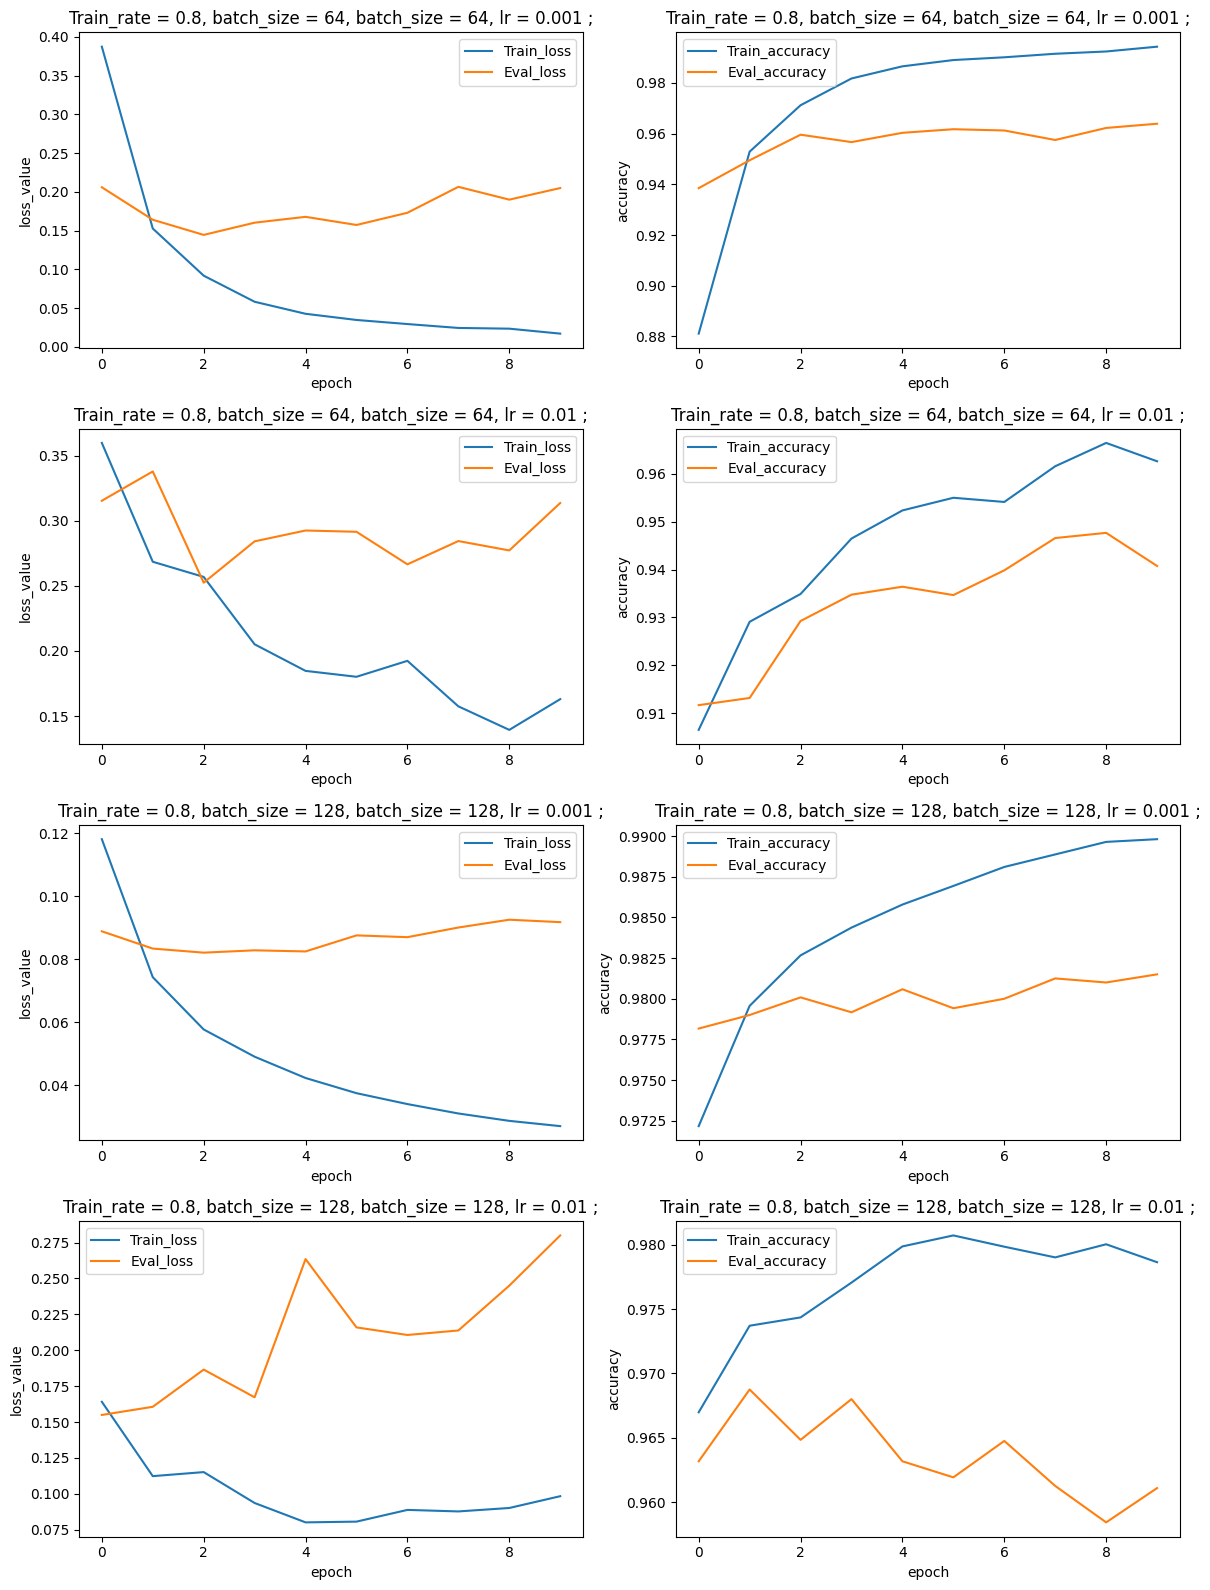

In [31]:
# 三层结构
linear_relu_stack = nn.Sequential(
    nn.Linear(28*28,512),
    nn.ReLU(), 
    nn.Linear(512,512),   
    nn.ReLU(),  
    nn.Linear(512,10)
)
graphname = 'train_result_3level.png'
multi_train(linear_relu_stack,graphname)




Train_rate = 0.8, batch_size = 64, batch_size = 64, lr = 0.001 ;
Model Train is start !
Epoch-1:  train loss = 0.3964, train accuary = 0.8780 ; eval loss = 0.2139, eval accuary = 0.9362  ;
Epoch-2:  train loss = 0.1597, train accuary = 0.9507 ; eval loss = 0.1948, eval accuary = 0.9398  ;
Epoch-3:  train loss = 0.0942, train accuary = 0.9708 ; eval loss = 0.1544, eval accuary = 0.9543  ;
Epoch-4:  train loss = 0.0639, train accuary = 0.9799 ; eval loss = 0.1715, eval accuary = 0.9537  ;
Epoch-5:  train loss = 0.0531, train accuary = 0.9834 ; eval loss = 0.1544, eval accuary = 0.9595  ;
Epoch-6:  train loss = 0.0410, train accuary = 0.9876 ; eval loss = 0.1709, eval accuary = 0.9595  ;
Epoch-7:  train loss = 0.0331, train accuary = 0.9892 ; eval loss = 0.1821, eval accuary = 0.9595  ;
Epoch-8:  train loss = 0.0305, train accuary = 0.9908 ; eval loss = 0.1774, eval accuary = 0.9592  ;
Epoch-9:  train loss = 0.0255, train accuary = 0.9925 ; eval loss = 0.1815, eval accuary = 0.9612  ;
Epo

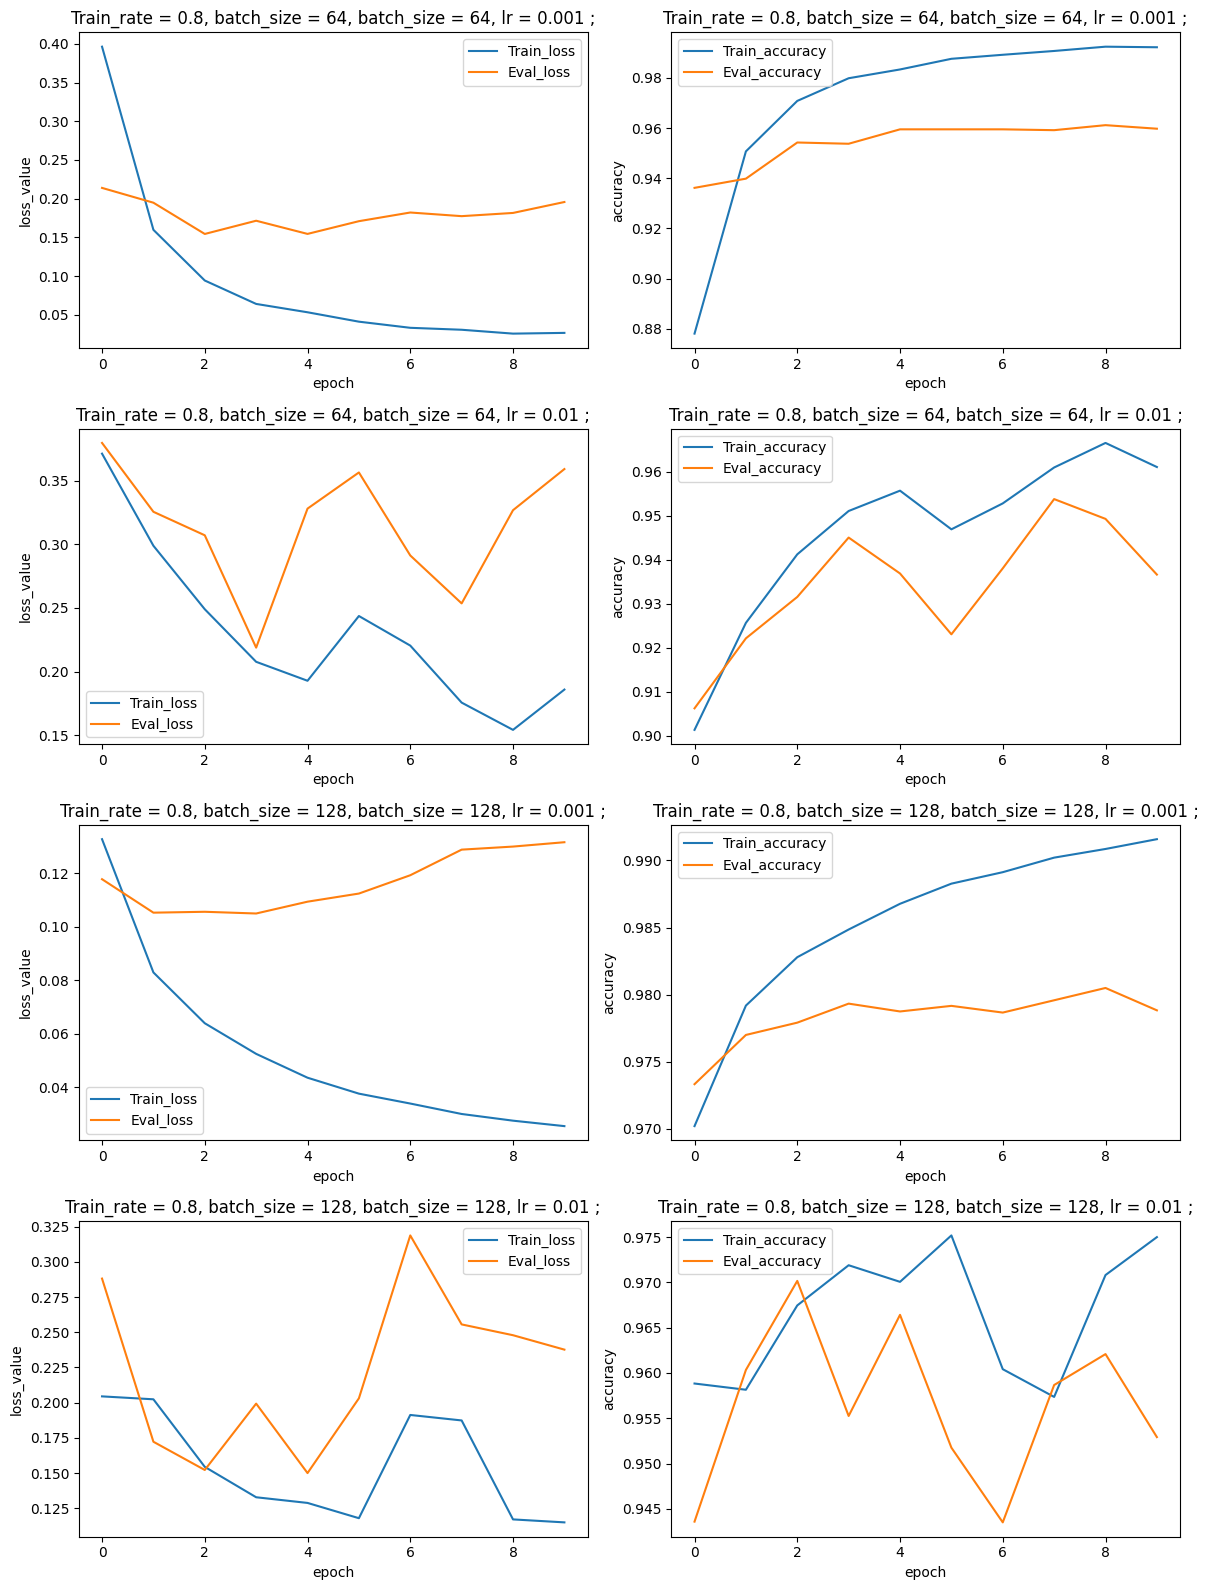

In [32]:
# 四层结构
linear_relu_stack2 = nn.Sequential(
    nn.Linear(28*28, 512),  # 输入层 -> 隐藏层1
    nn.ReLU(),
    nn.Linear(512, 512),     # 隐藏层1 -> 隐藏层2
    nn.ReLU(),
    nn.Linear(512, 256),     # 新增的隐藏层3（512→256）
    nn.ReLU(),               # 激活函数
    nn.Linear(256, 10)       # 隐藏层3 -> 输出层
)
graphname2 = 'train_result_4level.png'
multi_train(linear_relu_stack2,graphname2)


Train_rate = 0.8, batch_size = 64, batch_size = 64, lr = 0.001 ;
Model Train is start !
Epoch-1:  train loss = 0.4478, train accuary = 0.8593 ; eval loss = 0.2563, eval accuary = 0.9200  ;
Epoch-2:  train loss = 0.1733, train accuary = 0.9477 ; eval loss = 0.1581, eval accuary = 0.9518  ;
Epoch-3:  train loss = 0.1092, train accuary = 0.9676 ; eval loss = 0.1591, eval accuary = 0.9519  ;
Epoch-4:  train loss = 0.0817, train accuary = 0.9752 ; eval loss = 0.1429, eval accuary = 0.9584  ;
Epoch-5:  train loss = 0.0594, train accuary = 0.9825 ; eval loss = 0.1502, eval accuary = 0.9597  ;
Epoch-6:  train loss = 0.0523, train accuary = 0.9832 ; eval loss = 0.1646, eval accuary = 0.9579  ;
Epoch-7:  train loss = 0.0403, train accuary = 0.9877 ; eval loss = 0.1637, eval accuary = 0.9613  ;
Epoch-8:  train loss = 0.0335, train accuary = 0.9894 ; eval loss = 0.1940, eval accuary = 0.9531  ;
Epoch-9:  train loss = 0.0319, train accuary = 0.9901 ; eval loss = 0.1618, eval accuary = 0.9635  ;
Epo

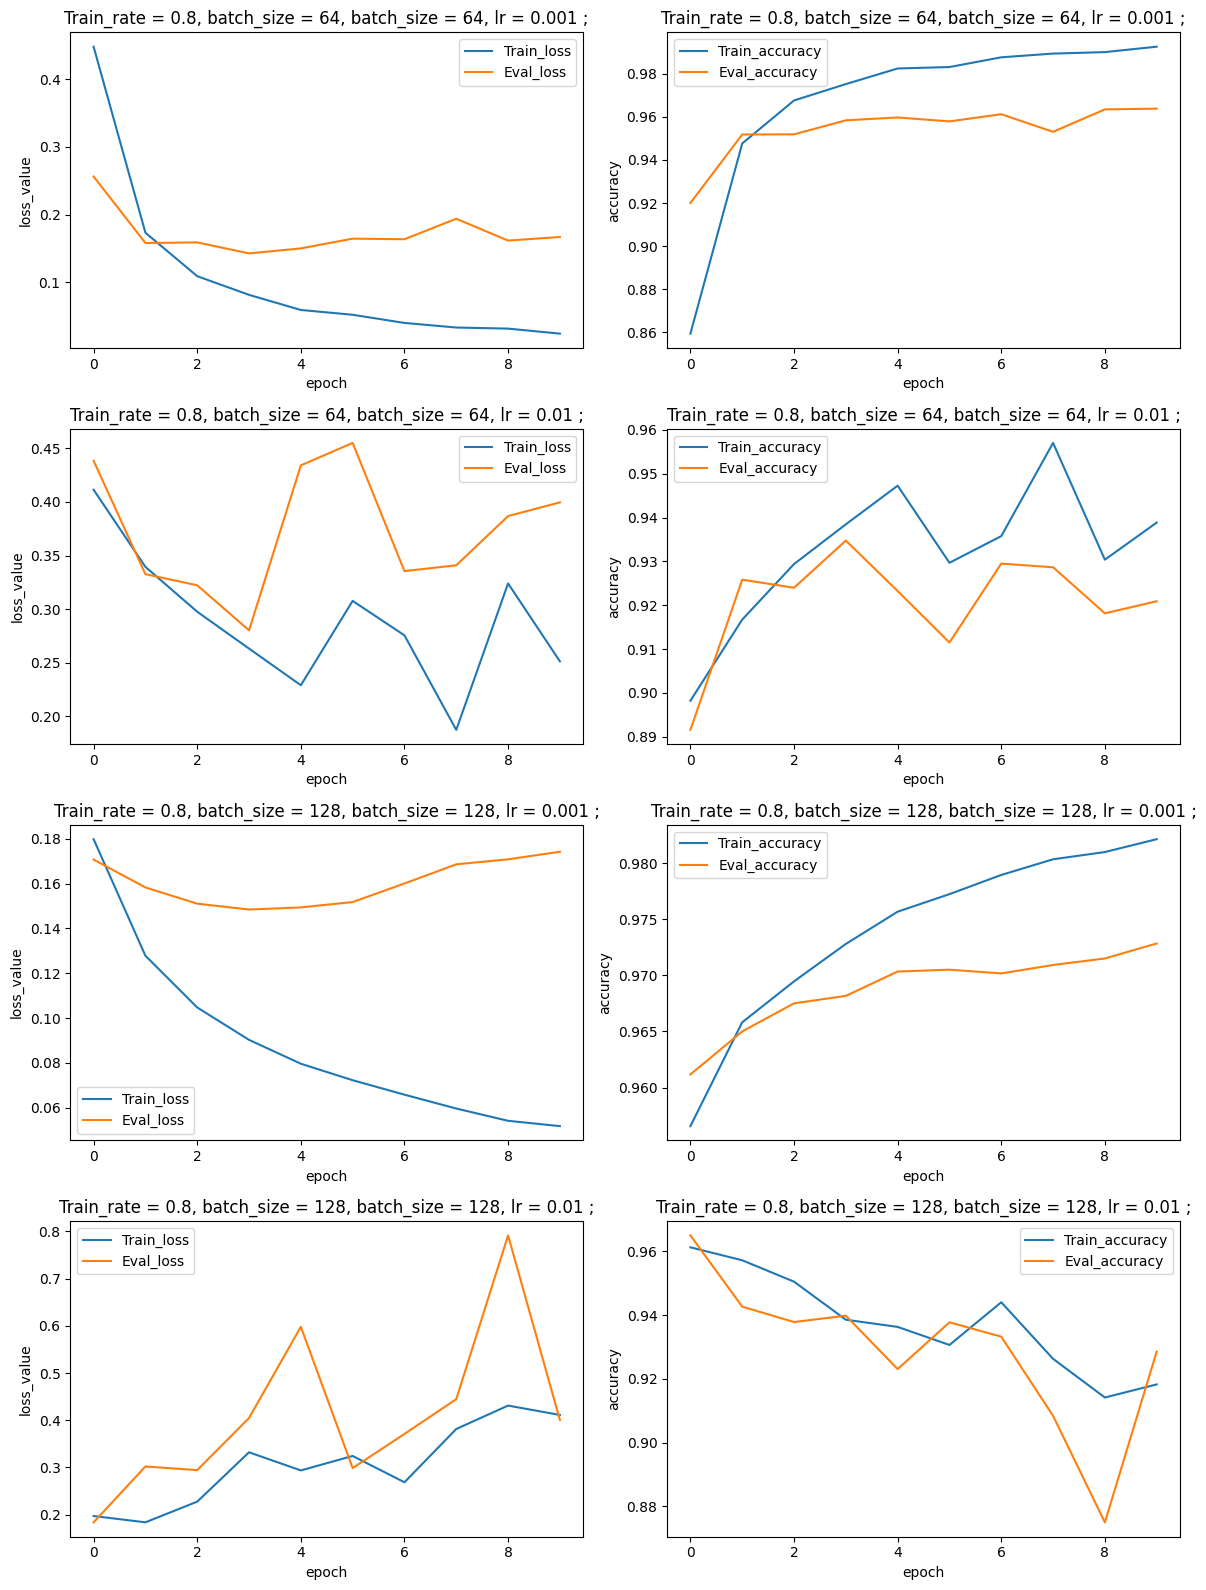

In [33]:
# 五层结构
linear_relu_stack3 = nn.Sequential(
    nn.Linear(28*28, 512),  # 输入层 -> 隐藏层1
    nn.ReLU(),
    nn.Linear(512, 512),     # 隐藏层1 -> 隐藏层2
    nn.ReLU(),
    nn.Linear(512, 256),     # 新增的隐藏层3（512→256）
    nn.ReLU(),               # 激活函数
    nn.Linear(256, 128),     # 新增的隐藏层3（512→256）
    nn.ReLU(),               # 激活函数
    nn.Linear(128, 10)       # 隐藏层3 -> 输出层
)
graphname3 = 'train_result_5level.png'
multi_train(linear_relu_stack3,graphname3)



